<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era_hindcast/blob/main/heat_map_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/
#         |__ models/
#         |__ output/
#         |__ heat_maps/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs
dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps' #where to save heatmaps

In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3
!pip install rasterio

     |████████████████████████████████| 1.0MB 7.6MB/s 
     |████████████████████████████████| 6.5MB 38.4MB/s 
     |████████████████████████████████| 15.3MB 277kB/s 
     |████████████████████████████████| 614kB 7.3MB/s 
     |████████████████████████████████| 19.1MB 311kB/s 


In [3]:
#import required libraries

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression

import pickle
import os
from random import seed
from datetime import datetime, date
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from pyproj import Transformer
import rasterio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
#define functions

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of province/territory names; ['Alberta'], ['British Columbia'], ['Alberta','British Columbia'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['Alberta','British Columbia'], ax = ax) #plots British Colubmia, and Alberta

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/province_borders/lpr_000b16a_e.shp'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial names
  prov_names = [
                'Newfoundland and Labrador',
                'Prince Edward Island',
                'Nova Scotia',
                'New Brunswick',
                'Quebec',
                'Ontario',
                'Manitoba',
                'Saskatchewan',
                'Alberta',
                'British Columbia',
                'Yukon',
                'Northwest Territories',
                'Nunavut'
  ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_names

  #define initial and final projections
  transformer = Transformer.from_crs('epsg:3347', 'epsg:4326') #manually reproject from Lambert Conformal Conic to WGS84 (latitude/longitude)

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_names.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      latBorder,lonBorder = transformer.transform(lonBorder, latBorder)
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy
        latBorder_segment,lonBorder_segment = transformer.transform(lonBorder_segment, latBorder_segment) 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def get_A(heat):

  """
  Returns the area (as a fraction of the total heatmap) which is above the half-maximum value

  heat --> sensitivity heat map (1D numpy array) of 1 station

  Example:
  A = get_A(heat = heat_mean)
  """

  halfMax = 0.5* (np.max(heat) - np.min(heat))
  n_hot_pixels = len(np.argwhere((heat - np.min(heat)) > halfMax))
  n_pixels = np.size(heat)
  A = n_hot_pixels / n_pixels

  return A

def make_heat(model, x_test, y_test, style_dict, days, iters_total, iters_one_pass, stationInds, verbose, tol):

  """
  model: 
      .h5 keras model
  x_test:
      tf tensor; test set of ERA data, input to model (shape = Ntest x 365 x height x width x channels)
  y_test:
      tf tensor; test set of streamflow data, target output of model (shape = Ntest x Nstations)
  style_dict:
      dictionary: {'style' : 'RISE' or 'gauss',
                   'params' : [h,w,p_1] or sigma}
          where [h,w,p_1] are the height/width/probability of perturbation of low-res mask (for RISE algorithm); sigma is the gaussian RMS width
  days:
      range of days in test set to perturb (e.g. days = range(0,365) will perturb the first 365 days in the test set)
  iters_total:
      number of total iterations of perturbation to do for each day in days
  iters_one_pass:
      number of iterations to do at one time (typically less than iters_total for memory limits)
  stationInds:
      indices of stations corresponding to the output neurons of the keras model
  verbose:
      0: print nothing
      1: print every 50th day
  tol:
      relative error threshold (when to stop pertubing model)
  """

  #initialize heat map as 3D numpy array: lat x lon x station
  heat_mean = np.zeros((np.size(x_test[0,0,:,:,0]), len(stationInds)))

  n_channels = np.shape(x_test)[-1] #number of channels of input video
  H = np.shape(x_test)[2] #height of input video, in pixels (latitude)
  W = np.shape(x_test)[3] #width of input video, in pixels (longitude)

  heat_prev = np.zeros((H*W,len(stationInds))) #initially, the previous heat map is 0's (for first pass)
  heat_curr = np.zeros((H*W,len(stationInds))) #also initialize the current heat map as 0's (will fill once calculated at end of first pass)
  kk = 0
  err = tol+1 #just to enter while loop
  while err > tol:
    
    # print(kk)
    #loop through specified days to generate mean sensitivity
    for day in days: #for each day that we will perturb

      #state progress
      if verbose:
        if np.mod(day,50)==0:
          print(' Day ' + str(day) + '/' + str(len(days))) 

      #number of iterations of perturbations for one forward pass through model
      iters = iters_one_pass 

      #define perturbation: rectangular as from RISE, or gaussian 
      if style_dict['style'] == 'RISE':
    
        h = style_dict['params'][0]
        w = style_dict['params'][1]
        p_1 = style_dict['params'][2]

        x_int = np.linspace(0,W,w) #low-res x indices
        y_int = np.linspace(0,H,h) #low-res y indices

        xnew = np.arange(W)
        ynew = np.arange(H) 

        perturb_small = np.random.choice([0,1],size = (iters,1,h,w), p = [1-p_1,p_1]) #binary perturbation on coarse grid
        perturb = np.half([interpolate.interp2d(x_int,y_int,perturb_small[iter][0])(xnew,ynew) for iter in range(iters)]) #perturbation is interpolated to finer grid

      elif style_dict['style'] == 'gauss':

        sigma = style_dict['params']

        x_int = np.arange(W)
        y_int = np.arange(H)
        x_mesh, y_mesh = np.meshgrid(x_int, y_int)

        #define gaussian perturbation for each iteration being passed
        perturb = np.half([np.exp( - ( (x_mesh - np.random.randint(0,W))**2 + (y_mesh - np.random.randint(0,H))**2 ) / (2*sigma**2) ) for iter in range(iters)])

      #copy/expand dimensions of the perturbation to be added to weather video
      perturb_2D = np.copy(perturb) #the 2D perturbation for each iteration of this pass
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),3),nchannels, axis = 3) #expand along channels in one image
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),1),365, axis = 1) #expand along images in one video

      xday = x_test[day] #current day in test set
      xday_iters = [xday for val in range(iters)] #repeat for each iteration (e.g. make copy for each perturbation)

      factor = np.random.choice([-1,1],p = [0.5,0.5]).astype('float16') #whether to add or subtract perturbation from input video, 50-50 chance of each
      perturb = factor*perturb

      x1 = perturb
      x2 = tf.convert_to_tensor(xday_iters)
      xday_iters_perturb = tf.math.add(x1,x2)

      x_all = tf.squeeze(tf.concat((tf.expand_dims(xday, axis = 0),xday_iters_perturb), axis = 0)) #'all' refers to original (xday) and perturbed (xday_iters_perturb)
      x_all_ds = tf.data.Dataset.from_tensor_slices(x_all).batch(batch_size = 64)
      y_all = model.predict(x_all_ds)

      yday = y_all[0] #first element is unperturbed model prediction
      yday_perturb = y_all[1:] #all others are perturbed model predictions for each iteration of perturbation

      for station in range(np.shape(y_all)[1]): #for each station, calculate heat map of sensitivity from sensitivty = |deltaQ| * perturbation

        yday_station = yday[station] #original unperturbed model prediction
        yday_station_perturb = yday_perturb[:,station]

        ydiffs = np.abs(np.reshape(yday_station - yday_station_perturb[:iters],(-1,1))) #magnitude difference between perturbed and unperturbed streamflow
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None] #get dimensions to match so delta can be multiplied by perturbation

        heat_iters = np.asarray(delta[:iters]) * np.asarray(perturb_2D)
        heat = np.mean(heat_iters[:iters], axis=0) 

        heat_mean[:,station] += heat.flatten() 

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters #delete for memory

    n_iters = iters_one_pass*(kk+1)
    heat_curr = np.copy(heat_mean) / n_iters
    err = np.mean(np.abs(heat_curr - heat_prev)) / np.mean(heat_prev)

    heat_prev = np.copy(heat_curr)

    kk += 1

  heat_mean = heat_mean /(iters_total * len(days))

  return heat_mean


def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

def get_ks(heat, radius, basins, eraLon, eraLat, stationLon, stationLat, stationInds, n_clusters, labels):

  """
  Calculates Kolmogorov-Smirnov (KS) D-statistic

  heat = sensitivity heat map, numpy array; dimensions of (n_lat*n_lon) x n_stations (e.g. 384 x 226 if there are 226 stations and the ERA5 input is 12 x 32 in space)
  radius = radius around stream gauge basins which counts as 'near' the watersheds (for in/near vs out/far distribution determination)
  basins = list of stream gauge basins (polygons from which exteriors are used to calculate in/near vs out/far)
  eraLon = np array of longitudes in ERA5 grid
  eraLat = np array of latitudes in ERA5 grid
  stationLon = np array of longitudes of all stream gauge stations
  stationLat = np array of latitudes of all stream gauge stations
  stationInds = np array of indices of stations in stationLon/Lat/basins to use
  n_clusters = int; number of streamflow regimes/clusters 
  labels = np array of cluster labels of each stream gauge station
  """
  
  #initialize
  heat_in_station = [None] * len(stationInds)
  heat_out_station = [None] * len(stationInds)
  inside_all_stations = [None] * len(stationInds)
  outside_all_stations = [None] * len(stationInds)
  heat_in_clusters = [None] * n_clusters
  heat_out_clusters = [None] * n_clusters

  x = eraLon #rename for readability when making xx and xxv
  y = eraLat
  xx,yy = np.meshgrid(x,y)
  xxv = xx.reshape(-1) #vector (array) where paired elements in xxv and yyv correspond to one pixel in heat map sensitivity space
  yyv = yy.reshape(-1)

  points = list(zip(xx.flatten(),yy.flatten())) #will loop through each point to see if sensitivity there is in/near or out/far from basins

  #loop through each station and determine in/out points/sensitivity
  for station in range(len(stationInds)):

    #initialize
    heat_in_this_station = []
    heat_out_this_station = []

    #heatmap/basin of the current station
    heat_station = heat[:,station]
    basin = stationBasins[station]
      
    #determine basin outlines  
    if basin is not None: #if basin polygon(s) exist -- some small basins do not have polygons from this source (see elif)
      
      # xb,yb = basin[0][0].exterior.xy #lon/lat (x/y) points of watershed/basin boundary
      xb,yb = basin.exterior.xy #lon/lat (x/y) points of watershed/basin boundary
      basinPath = matplotlib.path.Path(np.vstack((xb, yb)).T, closed = True) #convert to path to use contains_points method
      # inside = basinPath.contains_points(points, radius = radius) #in theory this statement should work -- sometimes had errors.  Manually calculate below instead.
    
    elif basin is None: #if basin shapefile is missing, use stream gauge location w/ radius buffer to estimate in/near pixels (these are small basins)

      xb = stationLon[stationInds][station] #basin outline taken to be single point at stream gauge
      yb = stationLat[stationInds][station]
      
    #create binary in/near (True) vs out/far (False)
    inside = np.zeros(np.size(Tmax[0])) #initialize inside/outside array
    for ii, point in enumerate(points): #for each point/pixel in ERA5 space
      d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2) #distance from point in ERA5 to all points around basin
      if np.min(d) <= radius: #if the nearest basin edge to current point in ERA5 is less than prescribed allowable radius
        inside[ii] = True #then this point in ERA5 is considered 'inside' (or near) this basin

    inside_this_station = np.squeeze(np.argwhere(inside==True)) #array of indices which are inside this station's basin
    outside_this_station = np.squeeze(np.argwhere(inside==False)) #array of indices which are outside this station's basin

    heat_in_station[station] = heat_station[inside_this_station] #sensitivity ('heat') of the inside/near pixels
    heat_out_station[station] = heat_station[outside_this_station] #sensitivity ('heat') of the outside/far pixels

    inside_all_stations[station] = inside_this_station #list of arrays of indices which are inside/near each stations' basin
    outside_all_stations[station] = outside_this_station #list of arrays of indices which are outside/far each stations' basin

  #find the sensitivity ('heat') of inside/near and outisde/far of all stations belonging to each cluster
  for cluster in range(n_clusters):

    #initialize
    heat_in_this_cluster = []
    heat_out_this_cluster = []
    stations_this_cluster = np.squeeze(np.argwhere(labels == cluster)) #stations in this cluster

    #print(stations_this_cluster)
    for station in stations_this_cluster: #for each station in the cluster
      for temp in heat_in_station[station]: #for each sensitivity ('heat') value within/near this station's basin
        heat_in_this_cluster.append(temp) #append the heat to the "inside cluster's" set
      for temp in heat_out_station[station]: #for each sensitivity ('heat') value outside/far from this station's basin
        heat_out_this_cluster.append(temp) #append the heat to the "outside cluster's" set

    heat_in_clusters[cluster] = heat_in_this_cluster
    heat_out_clusters[cluster] = heat_out_this_cluster

  #find unique pixels in each clusters' set of basins; some basins in same cluster can share pixels, but here we want unique indices for visualization
  unique_in_clusters = [None] * n_clusters

  for cluster in range(n_clusters): #for each cluster

    unique_in_this_cluster = [] #initialize
    stations_this_cluster = np.squeeze(np.argwhere(labels == cluster)) #stations in this cluster

    for station in stations_this_cluster: #for each station
      for ind in inside_all_stations[station]: #for each index within/near this stations' basin
        unique_in_this_cluster.append(ind) #append the index
    unique_in_clusters[cluster] = list(set(unique_in_this_cluster)) #since some stations in the same cluster have the same index, take only unique indices

  #now, calculate Kolmogorov-Smirnov D-Statistic as evaluated between inside/outside heat distributions for each cluster
  ks = np.empty(n_clusters)
  p = np.empty(n_clusters)
  for cluster in range(n_clusters):
    ks[cluster],p[cluster] = ks_2samp(heat_in_clusters[cluster], heat_out_clusters[cluster])

  return ks, p, heat_in_clusters, heat_out_clusters, unique_in_clusters

def build_fine_model(model_bulk, N_stations, learning_rate):
  
  """
  Returns the not-yet-trained fine-tuned model

  model_bulk: trained bulk model to be fine-tuned
  N_stations: number of stations for fine-tuning
  learning_rate: learning rate for fine-tuning

  """

  #clone bulk model weights
  model_fine = tf.keras.models.clone_model(model_bulk)
  model_fine.set_weights(model_bulk.get_weights())

  #remove last dense layer and add new dense layer with N_stations neurons
  model_fine.pop()
  model_fine.add(Dense(N_stations, activation = 'linear')) 
  
  #compile model
  model_fine.compile(
      loss=tf.keras.losses.MSE,
      optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
      )
  
  return model_fine

def build_bulk_model(learning_rate):

  """
  Returns the not-yet-trained bulk model

  learning_rate: learning rate for training the bulk model

  Architecture of this model:

    Convolutional layer: 32 1x1 filters
    Convolutional layer: 16 3x3 filters
    Convolutional layer: 32 3x3 filters
    Max pooling layer: 2x2 pool size

    Convolutional layer: 32 3x3 filters
    Convolutional layer: 32 3x3 filters
    Max pooling layer: global

    Dropout layer: dropout rate = 0.1

    LSTM layer: 80 units

    Dense layer: N_stations neurons

  """

  #CNN model

  model = Sequential()

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (1,1), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
              )
      )
  
  model.add(
      TimeDistributed(
          Conv2D(
              filters = 16, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
              )
      )
  
  model.add(
    TimeDistributed(
        Conv2D(
            filters = 16, 
            kernel_size = (3,3), 
            activation='relu',
            data_format='channels_last', 
            padding='same'
            ), 
            input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
            )
    )

  model.add(
      TimeDistributed(
          MaxPooling2D(
              pool_size = 2)
          )
      )

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ),
              )
      )

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              )
      )

  model.add(
      TimeDistributed(
          GlobalMaxPooling2D(
              data_format='channels_last')
          )
      )

  model.add(
      TimeDistributed(
          Flatten()
          )
      )

  model.add(
      Dropout(
          rate = 0.1
          )
      )

  #LSTM
  model.add(
      LSTM(
          80, 
           return_sequences=False
           )
      )

  #Dense
  model.add(
      Dense(
          np.shape(F)[1], 
          activation = 'linear'
          )
      )

  #compile
  model.compile(loss=tf.keras.losses.MSE,
                  optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
  
  return model

# Prep data

In [6]:
#load data

prov = ['British Columbia', 'Alberta'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data
basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle' #filename of pickle file which contains the basin outlines

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#unpack data
stationDrainageArea = np.array([np.double(area[1:]) for area in flowDict['stationDrainageArea']])
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flow_NF'] 
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [7]:
#select subset of stations

maxLat = 56. #maximum station latitude to include
stationInds = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<maxLat)[:,0]) #indices of stations which are below maximum latitude

F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds] #only use basins where stations are south of the maximum latitude
stationNames = flowDict['stationName'][stationInds]

In [8]:
#load DEM of region and characterize study basins

mosaic = rasterio.open(dir_data + '/AB_BC_mosaic.tif')
minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]
dem = mosaic.read(1)
dem = np.array(dem, dtype = np.float32)

minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]

stationGaugeElevation = dem[mosaic.index(x = stationLon[stationInds], y = stationLat[stationInds])] #calculate elevation (in m a.s.l.) of stream gauge

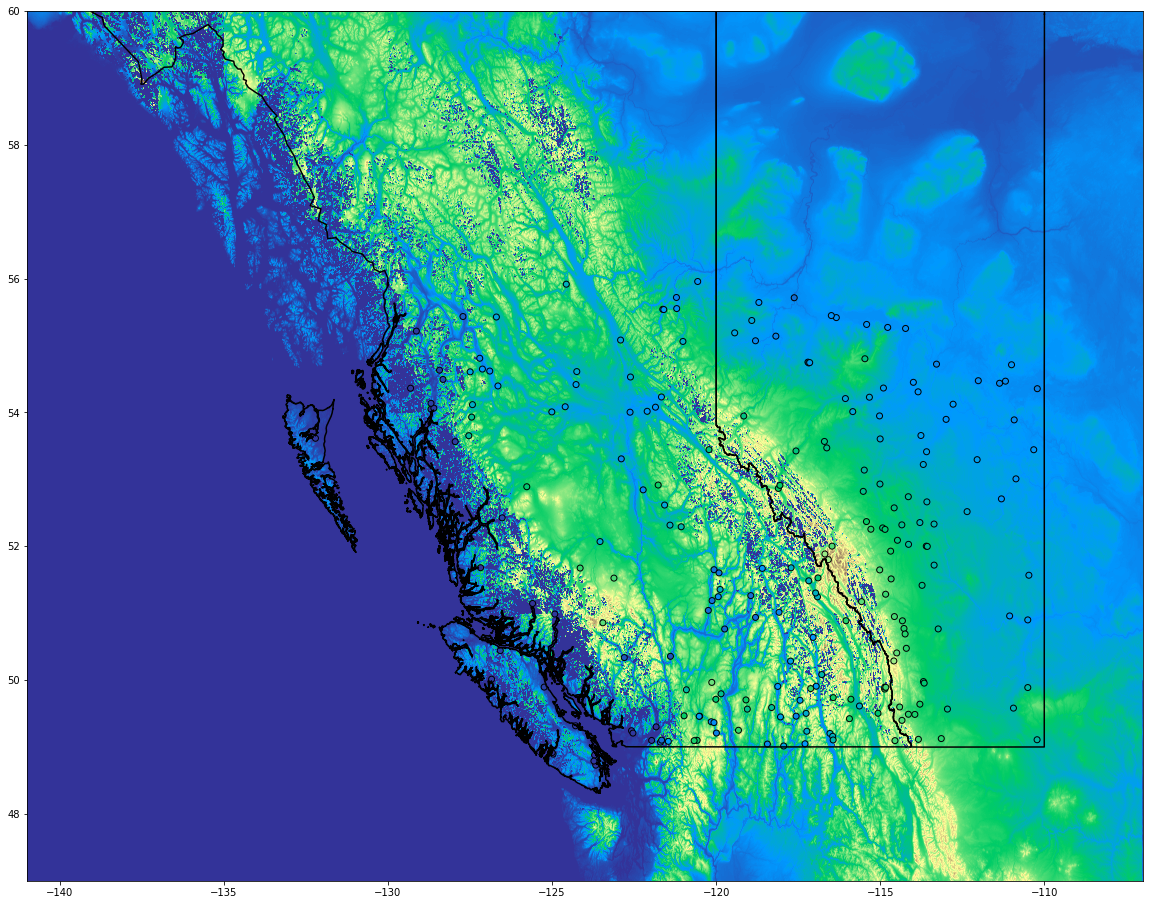

In [9]:
#visualize study region dem
fig, ax = plt.subplots(figsize = (20,16))
ax.imshow(dem, aspect = 'auto', vmin = 0, vmax = np.nanmax(dem), cmap = 'terrain', extent = extentDEM)
plot_prov_ax(prov = ['Alberta','British Columbia'], ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], c = stationGaugeElevation, edgecolor = 'k', cmap = 'terrain', vmin = 0, vmax = np.nanmax(dem))

In [10]:
print('Range of station elevation (in meters a.s.l.): ')
print('   Minimum: ', np.min(stationGaugeElevation))
print('   Maximum: ', np.max(stationGaugeElevation))
print('   Median:  ', np.median(stationGaugeElevation))

print('Range of station drainage area (in km^2): ')
print('   Minimum: ', np.min(stationDrainageArea))
print('   Maximum: ', np.max(stationDrainageArea))
print('   Median:  ', np.median(stationDrainageArea))

Range of station elevation (in meters a.s.l.): 
   Minimum:  8.0
   Maximum:  1706.0
   Median:   717.5
Range of station drainage area (in km^2): 
   Minimum:  6.22
   Maximum:  133000.0
   Median:   790.0


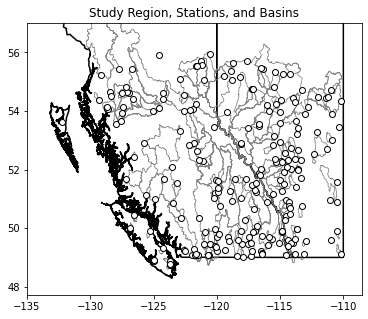

In [11]:
#visualize study region
fig, ax = plt.subplots(figsize = (6,5))

plot_prov_ax(prov, ax)
for basin in stationBasins:
  if basin is not None:
    x,y = basin.exterior.xy
    ax.plot(x, y, color = 'gray', linewidth = 0.75)
ax.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', zorder = 3)
ax.set_title('Study Region, Stations, and Basins')
ax.set_ylim(top = 57)
ax.set_xlim(left = -135)

plt.show()

In [12]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  #trim temp/precip data to only those values within bounding box
  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [13]:
#standardize data relative to training time period

#years/indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

#normalize flow wrt to training period for each station
Fnorm = np.empty_like(F)
Fmean = np.zeros(len(stationInds))
Fstd = np.zeros(len(stationInds))
for station in range(np.shape(F)[1]):
  Fmean[station] = np.mean(F[trainInds,station])
  Fstd[station] = np.std(F[trainInds,station])
  Fnorm[:,station] = (F[:,station] - np.mean(F[trainInds,station]))/np.std(F[trainInds,station])

In [14]:
#construct train and test predictor/target tensors

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_train = np.empty((Ntrain-365, 365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_val = np.empty((Nval, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,), dtype = np.float16)
x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#training
for ii in range(Ntrain-365):
  x_train[ii] = x_intermediate[ii:ii+365]

#validation
for ii in range(Nval):
  x_val[ii] = x_intermediate[ii + Ntrain - 365 : ii + Ntrain]

#testing
for ii in range(Ntest):
  x_test[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

#convert predict/target arrays to tensors
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)
x_train = tf.convert_to_tensor(x_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)
y_train = tf.convert_to_tensor(y_train)

In [15]:
# ALTERNATIVE:  Data can be structured as a generator which creates the input from x_intermediate.
#               Generators can be used when data cannot be loaded directly into RAM.  Memory issues
#               can come up especially from the multi-dimensional video structure.  We did not use
#               the generator approach here; rather, we loaded input/output directly to memory.  An
#               example of how to setup and train from generators is provided here.

# #training generator
# def gen_train():
#   for ii in range(Ntrain-365):
#     xx = tf.convert_to_tensor(x_intermediate[ii:ii+365])
#     yy = Fnorm[365+ii,:]
#     yield xx,yy

# #validation generator
# def gen_val():
#   for ii in range(Nval):
#     xx = tf.convert_to_tensor(x_intermediate[ii + Ntrain - 365 : ii + Ntrain])
#     yy = Fnorm[valInds[ii],:]
#     yield xx,yy

# #testing generator
# def gen_test():
#   for ii in range(Ntest):
#     xx = tf.convert_to_tensor(x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval])
#     yy = Fnorm[testInds[ii],:]
#     yield xx,yy

# #define datasets from these generators

# batch_size = 64

# train_dataset = tf.data.Dataset.from_generator(
#     gen_train,
#     (tf.float16, tf.float16),
#     (tf.TensorShape([365,12,32,3]), tf.TensorShape([226]))
#     ).shuffle(Ntrain).batch(batch_size)

# val_dataset = tf.data.Dataset.from_generator(
#     gen_val,
#     (tf.float16, tf.float16),
#     (tf.TensorShape([365,12,32,3]), tf.TensorShape([226]))
#     ).shuffle(Nval).batch(batch_size)

# test_dataset = tf.data.Dataset.from_generator(
#     gen_test,
#     (tf.float16, tf.float16),
#     (tf.TensorShape([365,12,32,3]), tf.TensorShape([226]))
#     ).shuffle(Ntest).batch(batch_size)

# #Example of use for training:

# callbacks = EarlyStopping(monitor='val_loss', 
#                         mode='min', 
#                         verbose=1, 
#                         patience = 5,
#                         restore_best_weights = True)

# model_bulk = build_bulk_model(learning_rate = 1e-4)
# model_bulk.fit(
#     train_dataset,
#     validation_data = val_dataset,
#     epochs = 200,
#     verbose = 1, 
#     callbacks = [callbacks]
#     )

# Cluster seasonal flow

In [16]:
#create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.zeros((len(stationInds), len_input))

flowseason = flowDict['all_flowseason_NF'][stationInds,:]
stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

for station in range(len(stationInds)):
  cluster_input[station,:365] = (flowseason[station,:] - np.mean(flowseason[station,:])) / np.std(flowseason[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

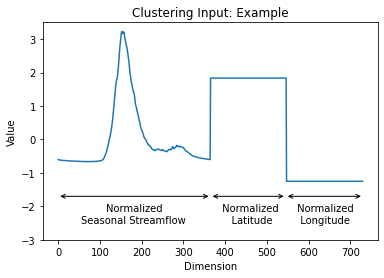

In [17]:
#visualize single input

saveIt = 0

fig, ax = plt.subplots()

ax.plot(cluster_input[0])
ax.set_xlabel('Dimension')
ax.set_ylabel('Value')
ax.set_title('Clustering Input: Example')
ax.set_ylim([-3,3.5])

p1 = [0, -1.7]
p2 = [365, -1.7]
pmid12 = np.mean([p1, p2])

p3 = [545, -1.7]
pmid23 = np.mean([p2,p3])

p4 = [730, -1.7]
pmid34 = np.mean([p3,p4])

plt.annotate(s='', xy=(p2[0],p2[1]), xytext=(p1[0],p1[1]), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=(p3[0],p3[1]), xytext=(p2[0],p2[1]), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=(p4[0],p4[1]), xytext=(p3[0],p3[1]), arrowprops=dict(arrowstyle='<->'))

ax.text(x = 55, y = -2.5, s = '        Normalized \nSeasonal Streamflow', fontsize = 10)
ax.text(x = 385, y = -2.5, s = ' Normalized \n    Latitude', fontsize = 10)
ax.text(x = 565, y = -2.5, s = ' Normalized \n  Longitude', fontsize = 10)

if saveIt:
  plt.savefig('clustering_input_example.png', bbox_inches = 'tight', dpi = 300)

plt.show()

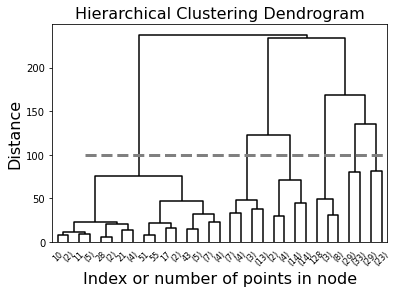

In [18]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Index or number of points in node", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [19]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [20]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern'
]

first_days_of_month = np.array([1,32,61,92,122,153,183,214,245,275,306,336]) #day-of-year of the first day of each month

months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

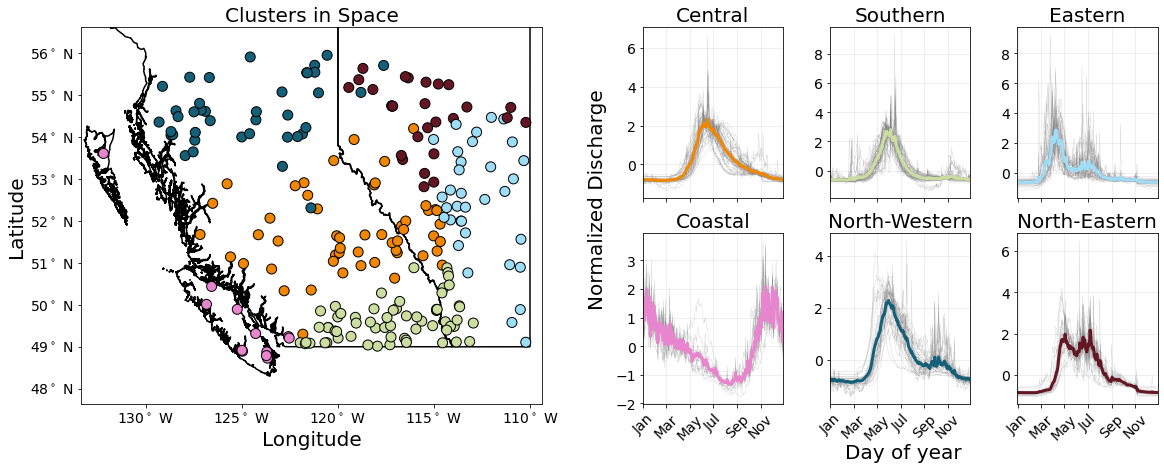

In [21]:
#visualize clustering results (spatial + temporal patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig = plt.figure(figsize = (16,7))

#left side: spatial map of stations, coloured by cluster to which they belong
ax0 = fig.add_subplot(1,2,1)
plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = fs-6)
ax0.set_xlabel('Longitude', fontsize = fs)
ax0.set_ylabel('Latitude', fontsize = fs)
ax0.set_title('Clusters in Space', fontsize = fs)
ax0.set_xlim((extentERA[0], extentERA[1]))
ax0.set_ylim((extentERA[2], extentERA[3]))

#right side: subplots of seasonal streamflow of each cluster 
subplot_inds = [3,4,5,9,10,11] #the right-side indices in a 2row x 6col grid, for plotting the temporal pattern
for cluster, subplot_ind in enumerate(subplot_inds):
  ax = fig.add_subplot(2,6,subplot_ind+1)
  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')
  if cluster<3:
    ax.set_xticklabels([])
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = fs - 6)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

ax0.text(-107,50, 'Normalized Discharge', fontsize = fs, rotation = 90) #manually add axis labels to control tight-layout aesthetic 
ax0.text(-93.6,46.35, 'Day of year', fontsize = fs)

#edit ticklabels
xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax0.get_xticklabels()]
ax0.set_xticklabels(xtls)
ytls = [item.get_text() + '$^\circ$ N' for item in ax0.get_yticklabels()]
ax0.set_yticklabels(ytls)

if saveIt:
  plt.savefig('cluster_patterns.png', bbox_inches = 'tight', dpi = 300)

if saveEPS:
  plt.savefig('cluster_patterns.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [22]:
#for each cluster, display elevation stats

for cluster in range(n_clusters_seasonal):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  print(cluster_names[cluster])
  print('   Range of station elevation (in meters a.s.l.): ')
  print('     Minimum: ', np.min(stationGaugeElevation[inds]))
  print('     Maximum: ', np.max(stationGaugeElevation[inds]))
  print('     Mean:  ', np.mean(stationGaugeElevation[inds]))

  # print('Range of station drainage area (in km^2): ')
  # print('   Minimum: ', np.min(stationDrainageArea[stationInds][inds]))
  # print('   Maximum: ', np.max(stationDrainageArea[stationInds][inds]))
  # print('   Median:  ', np.median(stationDrainageArea[stationInds][inds]))

Central
   Range of station elevation (in meters a.s.l.): 
     Minimum:  8.0
     Maximum:  1706.0
     Mean:   794.6923
Southern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  38.0
     Maximum:  1660.0
     Mean:   930.9355
Eastern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  523.0
     Maximum:  962.0
     Mean:   751.67645
Coastal
   Range of station elevation (in meters a.s.l.): 
     Minimum:  10.0
     Maximum:  87.0
     Mean:   36.25
North-Western
   Range of station elevation (in meters a.s.l.): 
     Minimum:  8.0
     Maximum:  917.0
     Mean:   520.6923
North-Eastern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  494.0
     Maximum:  956.0
     Mean:   685.6667


In [23]:
#for each cluster, display area stats

for cluster in range(n_clusters_seasonal):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  print(cluster_names[cluster])
  print('Range of station drainage area (in km^2): ')
  print('   Minimum: ', np.min(stationDrainageArea[stationInds][inds]))
  print('   Maximum: ', np.max(stationDrainageArea[stationInds][inds]))
  print('   Median:  ', np.median(stationDrainageArea[stationInds][inds]))

Central
Range of station drainage area (in km^2): 
   Minimum:  21.0
   Maximum:  55400.0
   Median:   1580.0
Southern
Range of station drainage area (in km^2): 
   Minimum:  6.22
   Maximum:  11500.0
   Median:   288.5
Eastern
Range of station drainage area (in km^2): 
   Minimum:  44.4
   Maximum:  4700.0
   Median:   579.5
Coastal
Range of station drainage area (in km^2): 
   Minimum:  10.3
   Maximum:  480.0
   Median:   193.5
North-Western
Range of station drainage area (in km^2): 
   Minimum:  13.2
   Maximum:  50300.0
   Median:   2850.0
North-Eastern
Range of station drainage area (in km^2): 
   Minimum:  140.0
   Maximum:  74600.0
   Median:   1610.0


# Train bulk and fine-tuned models

In [24]:
del x_train, x_val, y_train, y_val

In [106]:
#set of random seeds to use for reproducability
seeds = [00, 11, 22, 33, 44, 55, 66, 77, 88, 99]
Nmodels = 1

#parameters for heat maps
sigma = 1.5 #radius of perturbation
style_dict = {'style' : 'gauss', #style of perturbation: gaussian (not RISE/rectangular)
              'params' : sigma}
days_heat = np.arange(365)#range(Ntest) #days in test set to perturb
iters_total = 200 #total iterations of perturbation
iters_one_pass = 10 #number of iterations to pass through model at one time (too high --> RAM issues)
tol = 5e-1

Nlat = np.shape(Tmax)[1]
Nlon = np.shape(Tmax)[2]
Npx = Nlat*Nlon
Ndays = len(days_heat)
Nstations = len(stationInds)

heat_fine = np.zeros((Npx*Ndays, Nstations, Nmodels), dtype = np.float16)

#for each random seed (one seed = one bulk / set of fine-tuned models; 10 seeds --> 10 model ensemble)
for ii, s in enumerate(seeds[:Nmodels]):

##### FINE-TUNING

  #prep fine-tune target output
  y_test_predict_fine_all = np.empty_like(y_test)

  #for each streamflow cluster, make/train/save fine-tuned model/output/heatmaps  

  for cluster in range(n_clusters_seasonal):

    print('Training fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

    #load model 
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster
    
    #create target datasets (note: x is the same, y is different (same spatial input, different station targets))
    y_test_fine_current = tf.convert_to_tensor(y_test.numpy()[:,stations_fine])

    #predict train/val/test streamflow
    # y_test_predict_fine = model_fine.predict(x_test, batch_size = batch_size, verbose = 0)

    #reorganize predictions into array that matches the bulk train/val/test structure
    # for kk, station_fine in enumerate(stations_fine): #for each station/index in this cluster
    #   y_test_predict_fine_all[:,station_fine] = y_test_predict_fine[:,kk]

    #for each day to perturb
    print(' Making heat maps')
    for day in range(Ndays):

      #generate fine-tuned heat maps
      print('   Day: ' + str(day+1) + ' / ' + str(Ndays))
      heat_mean_cluster = make_heat(
          model = model_fine, 
          x_test = tf.expand_dims(x_test[day], axis = 0), 
          y_test = tf.expand_dims(y_test[day], axis = 0), 
          style_dict = style_dict, 
          days = np.array([0]), 
          iters_total = iters_total, 
          iters_one_pass = iters_one_pass, 
          stationInds = stations_fine,
          verbose = 0,
          tol = tol
          )
      
      for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
        heat_fine[Npx*day:Npx*(day+1),station,ii] = heat_mean_cluster[:,zz]

  heat_mean_fine = np.mean(heat_fine, axis = -1)
  #save fine-tuned heatmaps
  fileName = 'heat_mean_fine_series' + str(ii) + '.csv'
  # np.savetxt(dir_heat + '/' + fileName, heat_mean_fine, delimiter = ',')

  #save fine-tuned model predictions


Training fine model, cluster 1 / 6
 Making heat maps
   Day: 1 / 365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:228: RuntimeWarning: divide by zero encountered in double_scalars


   Day: 2 / 365
   Day: 3 / 365
   Day: 4 / 365
   Day: 5 / 365
   Day: 6 / 365
   Day: 7 / 365
   Day: 8 / 365
   Day: 9 / 365
   Day: 10 / 365
   Day: 11 / 365
   Day: 12 / 365
   Day: 13 / 365
   Day: 14 / 365
   Day: 15 / 365
   Day: 16 / 365
   Day: 17 / 365
   Day: 18 / 365
   Day: 19 / 365
   Day: 20 / 365
   Day: 21 / 365
   Day: 22 / 365
   Day: 23 / 365
   Day: 24 / 365
   Day: 25 / 365
   Day: 26 / 365
   Day: 27 / 365
   Day: 28 / 365
   Day: 29 / 365
   Day: 30 / 365
   Day: 31 / 365
   Day: 32 / 365
   Day: 33 / 365
   Day: 34 / 365
   Day: 35 / 365
   Day: 36 / 365
   Day: 37 / 365
   Day: 38 / 365
   Day: 39 / 365
   Day: 40 / 365
   Day: 41 / 365
   Day: 42 / 365
   Day: 43 / 365
   Day: 44 / 365
   Day: 45 / 365
   Day: 46 / 365
   Day: 47 / 365
   Day: 48 / 365
   Day: 49 / 365
   Day: 50 / 365
   Day: 51 / 365
   Day: 52 / 365
   Day: 53 / 365
   Day: 54 / 365
   Day: 55 / 365
   Day: 56 / 365
   Day: 57 / 365
   Day: 58 / 365
   Day: 59 / 365
   Day: 60 / 365
   Da

In [ ]:
saveIt = 0
if saveIt:
  fileName = 'heat_mean_fine_series.csv'
  np.savetxt(dir_heat + '/' + fileName, heat_mean_fine, delimiter = ',')

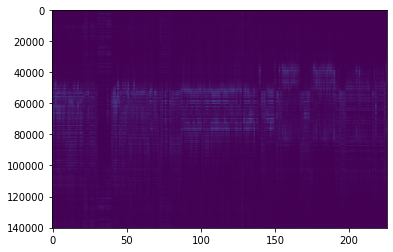

In [90]:
plt.imshow(np.double(heat_fine[:,:,0]), aspect = 'auto')

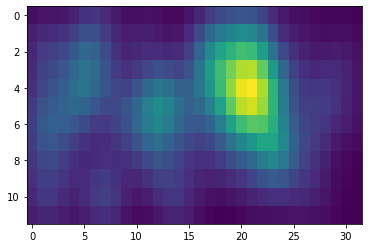

In [107]:
station = 131
day = 120
zz = np.double(heat_mean_fine[Npx*day:Npx*(day+1),kk].reshape(Nlat,Nlon))

zz = np.double(np.mean(heat_mean_fine[Npx*day:Npx*(day+1),:], axis = -1).reshape(Nlat,Nlon))

plt.imshow(zz, aspect = 'auto')

In [113]:
A_daily = np.zeros((Ndays, Nstations))
S_daily = np.zeros((Ndays, Nstations))
for day in range(Ndays):
  for station in range(Nstations):
    heat = heat_mean_fine[Npx*day:Npx*(day+1), station]
    A_daily[day,station] = get_A(heat)
    S_daily[day,station] = np.max(heat)

A_daily_cluster_mean = np.zeros((Ndays, n_clusters_seasonal))
A_daily_cluster_std = np.zeros((Ndays, n_clusters_seasonal))
S_daily_cluster_mean = np.zeros((Ndays, n_clusters_seasonal))
S_daily_cluster_std = np.zeros((Ndays, n_clusters_seasonal))
for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  A_daily_cluster_mean[:,cluster] = np.mean(A_daily[:,inds], axis = -1)
  A_daily_cluster_std[:,cluster] = np.std(A_daily[:,inds], axis = -1)
  S_daily_cluster_mean[:,cluster] = np.mean(S_daily[:,inds], axis = -1)
  S_daily_cluster_std[:,cluster] = np.std(S_daily[:,inds], axis = -1)

In [117]:
#smooth

window = 11
kernel = np.ones(window) / window

for station in range(Nstations):

  A_daily[:,station] = np.convolve(A_daily[:,station], kernel, mode = 'same')
  S_daily[:,station] = np.convolve(S_daily[:,station], kernel, mode = 'same')

for cluster in range(n_clusters_seasonal):

  A_daily_cluster_mean[:,cluster] = np.convolve(A_daily_cluster_mean[:,cluster], kernel, mode = 'same')
  S_daily_cluster_mean[:,cluster] = np.convolve(S_daily_cluster_mean[:,cluster], kernel, mode = 'same')

  A_daily_cluster_std[:,cluster] = np.convolve(A_daily_cluster_std[:,cluster], kernel, mode = 'same')
  S_daily_cluster_std[:,cluster] = np.convolve(S_daily_cluster_std[:,cluster], kernel, mode = 'same')

wedge = int((window - 1)/2)

A_daily = A_daily[wedge:-wedge]
S_daily = S_daily[wedge:-wedge]

A_daily_cluster_mean = A_daily_cluster_mean[wedge:-wedge]
S_daily_cluster_mean = S_daily_cluster_mean[wedge:-wedge]

A_daily_cluster_std = A_daily_cluster_std[wedge:-wedge]
S_daily_cluster_std = S_daily_cluster_std[wedge:-wedge]


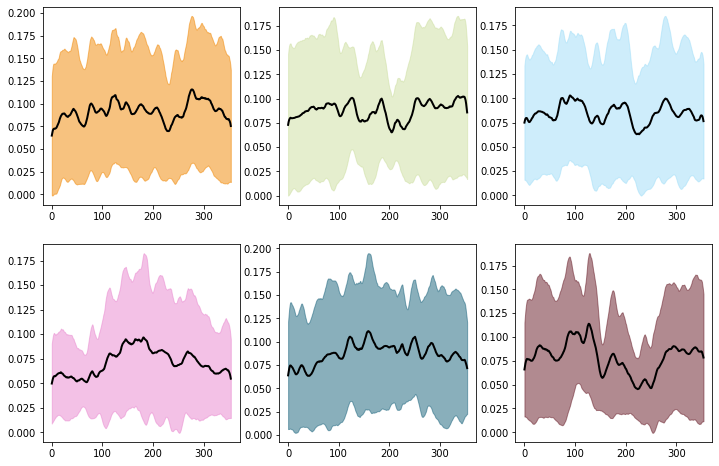

In [120]:
nrows = 2
ncols = 3#np.ceil(n_clusters_seasonal / nrows, dtype = 'int')

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):
  # inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  y1 = A_daily_cluster_mean[:,cluster] + 2*A_daily_cluster_std[:,cluster]
  y2 = A_daily_cluster_mean[:,cluster] - 2*A_daily_cluster_std[:,cluster]
  x = np.arange(len(y1))
  ax.fill_between(x, y1, y2, color = rgbas_array[cluster,:], alpha = 0.5)
  ax.plot(A_daily_cluster_mean[:,cluster], 'k', linewidth = 2)

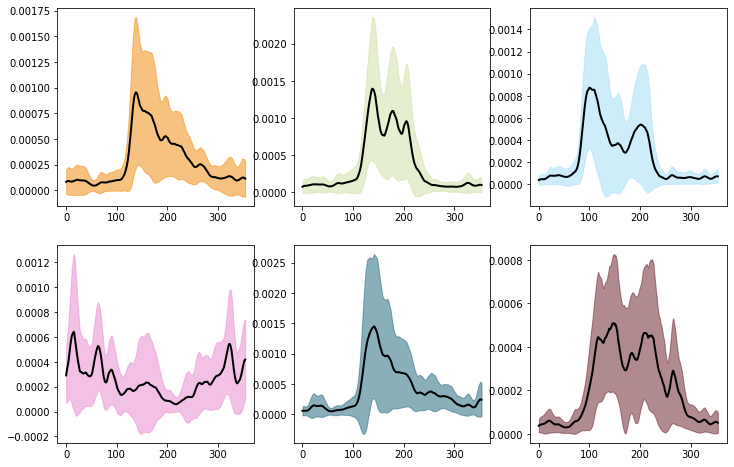

In [121]:
nrows = 2
ncols = 3#np.ceil(n_clusters_seasonal / nrows, dtype = 'int')

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):
  # inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  y1 = S_daily_cluster_mean[:,cluster] + 2*S_daily_cluster_std[:,cluster]
  y2 = S_daily_cluster_mean[:,cluster] - 2*S_daily_cluster_std[:,cluster]
  x = np.arange(len(y1))
  ax.fill_between(x, y1, y2, color = rgbas_array[cluster,:], alpha = 0.5)
  ax.plot(S_daily_cluster_mean[:,cluster], 'k', linewidth = 2)

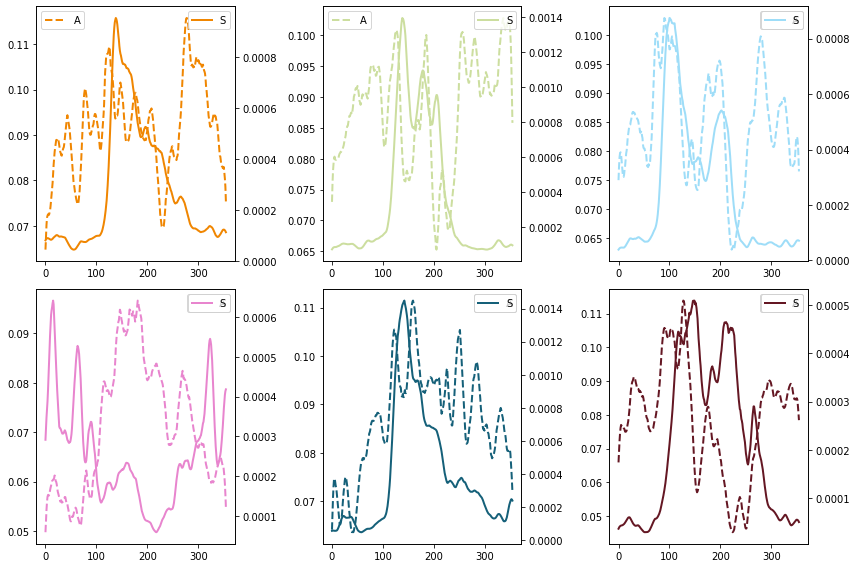

In [122]:
nrows = 2
ncols = 3#np.ceil(n_clusters_seasonal / nrows, dtype = 'int')

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):

  ax.plot(A_daily_cluster_mean[:,cluster], color = rgbas_array[cluster,:], linewidth = 2, label = 'A', linestyle = '--')
  ax2 = ax.twinx()
  ax2.plot(S_daily_cluster_mean[:,cluster], color = rgbas_array[cluster,:], linewidth = 2, label = 'S')
  ax.legend()
  ax2.legend()

plt.tight_layout()

In [ ]:
inds = np.squeeze(np.argwhere(seasonal_clustering.labels_==5))
cluster_input = heat_mean_fine[:,inds].reshape(365, Npx)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=3, color_threshold = 0, above_threshold_color = 'k')

In [129]:
n_clusters = 4
model = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

IndexError: ignored

# Ensemble analysis: All runs

In [ ]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#initialize
NSE_fine_runs = np.empty((len(runs), len(stationInds))) #fine-tuned NSE on test set
NSE_bulk_runs = np.empty((len(runs), len(stationInds))) #bulk NSE on test set
dNSE_runs = np.empty((len(runs), len(stationInds))) #difference in NSE from fine-tuning

A_fine_runs = np.empty((len(runs), len(stationInds))) #A from fine-tuned heatmaps on test set
A_bulk_runs = np.empty((len(runs), len(stationInds))) #A from bulk heatmaps on test set
dA_runs = np.empty((len(runs), len(stationInds))) #difference in A from fine-tuning

heat_mean_fine_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #fine-tuned heatmaps of each run
heat_mean_bulk_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #bulk heatmaps of each run

y_test_predict_bulk_runs = np.empty((len(runs), Ntest, len(stationInds))) #bulk model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run

y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  #load modelled streamflow
  filename_train_bulk = 'y_train_bulk_predict_' + str(run) + '.csv'
  filename_val_bulk = 'y_val_bulk_predict_' + str(run) + '.csv'
  filename_test_bulk = 'y_test_bulk_predict_' + str(run) + '.csv'
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'
  y_train_predict_bulk = np.asarray(pd.read_csv(dir_output + '/' + filename_train_bulk, header = None))
  y_val_predict_bulk = np.asarray(pd.read_csv(dir_output + '/' + filename_val_bulk, header = None))
  y_test_predict_bulk = np.asarray(pd.read_csv(dir_output + '/' + filename_test_bulk, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))
  y_test_predict_bulk_runs[ii,:,:] = y_test_predict_bulk
  y_test_predict_fine_runs[ii,:,:] = y_test_predict_fine
  y_all_predict_fine_runs[ii,:,:] = np.vstack((y_train_predict_fine, y_val_predict_fine, y_test_predict_fine))

  #load heat maps
  filename_bulk = 'heat_mean_bulk_' + str(run) + '.csv'
  filename_fine = 'heat_mean_fine_' + str(run) + '.csv'
  heat_mean_bulk = np.asarray(pd.read_csv(dir_heat + '/' + filename_bulk, header = None))
  heat_mean_fine = np.asarray(pd.read_csv(dir_heat + '/' + filename_fine, header = None))
  heat_mean_bulk_runs[ii,:,:] = heat_mean_bulk
  heat_mean_fine_runs[ii,:,:] = heat_mean_fine

  #initialize NSE train/val/test bulk/fine and A bulk/fine arrays of this current run
  NSE_fine = np.empty((len(stationInds),))
  NSE_bulk = np.empty((len(stationInds),))
  NSE_train_fine = np.empty((len(stationInds),))
  NSE_train_bulk = np.empty((len(stationInds),))
  NSE_val_fine = np.empty((len(stationInds),))
  NSE_val_bulk = np.empty((len(stationInds),))
  NSE_test_fine = np.empty((len(stationInds),))
  NSE_test_bulk = np.empty((len(stationInds),))
  A_fine = np.zeros((len(stationInds),))
  A_bulk= np.zeros((len(stationInds),))

  #loop through each station and calculate NSE and A
  for station in range(len(stationInds)):

#####calculate NSE

    #calculate train/val/test on fine/bulk models -- we'll use test NSE for evaluation but calculate all for interest sake
    NSE_train_fine[station] = nse(
        y_obs   = y_train[:,station],
        y_model = y_train_predict_fine[:,station]
        )
    NSE_val_fine[station] = nse(
        y_obs   = y_val[:,station],
        y_model = y_val_predict_fine[:,station]
        )
    NSE_test_fine[station] = nse(
        y_obs   = y_test[:,station],
        y_model = y_test_predict_fine[:,station]
        )
    NSE_train_bulk[station] = nse(
        y_obs   = y_train[:,station],
        y_model = y_train_predict_bulk[:,station]
        )
    NSE_val_bulk[station] = nse(
        y_obs   = y_val[:,station],
        y_model = y_val_predict_bulk[:,station]
        )
    NSE_test_bulk[station] = nse(
        y_obs   = y_test[:,station],
        y_model = y_test_predict_bulk[:,station]
        )

#####calculate A
    A_bulk[station] = get_A(heat = heat_mean_bulk[:,station])
    A_fine[station] = get_A(heat = heat_mean_fine[:,station])

  dNSE = NSE_test_fine - NSE_test_bulk
  dA = A_fine - A_bulk

  NSE_fine_runs[ii,:] = np.asarray(NSE_test_fine)
  NSE_bulk_runs[ii,:] = np.asarray(NSE_test_bulk)
  dNSE_runs[ii,:] = dNSE

  A_fine_runs[ii,:] = A_fine
  A_bulk_runs[ii,:] = A_bulk
  dA_runs[ii,:] = dA

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [ ]:
#also calculate NSE of the model ensemble average streamflow, rather than model-by-model NSE

NSE_bulk = np.empty(len(stationInds))
NSE_fine = np.empty(len(stationInds))

for station in range(len(stationInds)):

  NSE_bulk[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_bulk_runs,axis = 0)[:,station]
  )

  NSE_fine[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_fine_runs,axis = 0)[:,station]
  )

print('NSE test bulk ensemble = ' + str(np.round(np.median(NSE_bulk), decimals = 2)))
print('NSE test fine ensemble = ' + str(np.round(np.median(NSE_fine), decimals = 2)))

NSE test bulk ensemble = 0.66
NSE test fine ensemble = 0.68


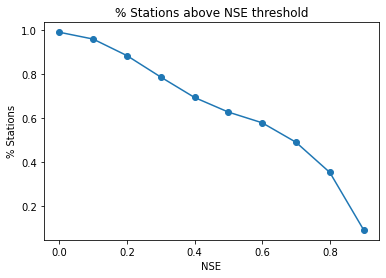

In [ ]:
#find % of stations with NSE > threshold (particularly, NSE > 0.8)
thresholds = np.arange(0,1,0.1)
frac = [len(np.argwhere(NSE_fine > threshold))/226 for threshold in thresholds]

plt.plot(thresholds, frac)
plt.scatter(thresholds, frac)
plt.title('% Stations above NSE threshold')
plt.xlabel('NSE')
plt.ylabel('% Stations')
plt.show()

In [ ]:
#normalize each heat maps to have zero mean and unity variance -- want to compare spatial form of sensitivity

#initialize
heat_mean_fine_runs_norm = np.zeros_like(heat_mean_fine_runs)
heat_mean_bulk_runs_norm = np.zeros_like(heat_mean_bulk_runs)

#for each station and run, load/normalize each bulk/fine heat map
for station in range(len(stationInds)):
  for run in range(len(runs)):

    hh = heat_mean_fine_runs[run,:,station]
    heat_mean_fine_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

    hh = heat_mean_bulk_runs[run,:,station]
    heat_mean_bulk_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

#calculate ensemble mean heat map for each station
heat_fine_ensemble_mean = heat_mean_fine#heat_mean_fine_runs_norm[0]#
heat_fine_ensemble_mean = np.mean(heat_mean_fine_runs_norm, axis = 0)
heat_bulk_ensemble_mean = np.mean(heat_mean_bulk_runs_norm, axis = 0)

cluster_heat_fine_mean = []
cluster_heat_bulk_mean = []

#calculate ensemble mean heat map for each cluster
for cluster in range(n_clusters_seasonal):

  inds = np.argwhere(seasonal_clustering.labels_ == cluster).reshape(-1,1) #indices of the cluster

  cluster_heat_mean_fine_current = np.squeeze(np.mean(heat_fine_ensemble_mean[:,inds], axis = 1))
  cluster_heat_mean_bulk_current = np.squeeze(np.mean(heat_bulk_ensemble_mean[:,inds], axis = 1))
  
  cluster_heat_fine_mean.append(cluster_heat_mean_fine_current)
  cluster_heat_bulk_mean.append(cluster_heat_mean_bulk_current)

In [ ]:
#calculate sensitive areas on ensemble mean heat maps
A_fine = np.zeros((len(stationInds),))
A_bulk= np.zeros((len(stationInds),))

for station in range(len(stationInds)):
  A_bulk[station] = get_A(heat = heat_bulk_ensemble_mean[:,station])
  A_fine[station] = get_A(heat = heat_fine_ensemble_mean[:,station])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


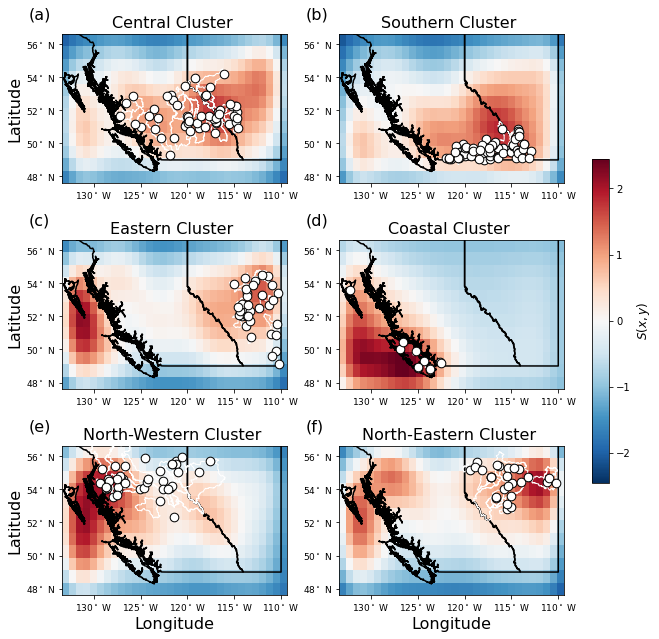

In [ ]:
#visualize fine-tuned ensemble mean heatmaps for each cluster

saveIt = 0
saveEPS = 0

fs = 16
abc = ['(a)','(b)','(c)','(d)','(e)','(f)']

nrows = 3
ncols = 2

vmax = np.max(np.abs(cluster_heat_fine_mean))
vmin = -vmax#np.min(cluster_heat_fine_mean)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols,3*nrows))

for cluster, ax in enumerate(axes.flatten()): #for each cluster

  inds = np.argwhere(seasonal_clustering.labels_ == cluster).reshape(-1,1) #indices of stations in this cluster
  im = ax.imshow(cluster_heat_fine_mean[cluster].reshape(np.shape(Tmax[0])), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA, vmin = vmin, vmax = vmax)

  #plot the basin of each cluster overtop of the heatmap
  for ind in inds:
    basin = stationBasins[ind[0]]
    if basin is not None:
      x,y = basin.exterior.xy
      ax.plot(x,y,'w', linewidth = 1, zOrder = 3)

  ax.scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 75, facecolor = 'w', edgecolor = 'k', zOrder = 4) #stream gauge stations
  plot_prov_ax(prov = prov, ax = ax) #provincial borders
  
  ax.tick_params(labelsize = fs-4)
  if cluster == 4 or cluster == 5:
    ax.set_xlabel('Longitude', fontsize = fs)
  if cluster == 0 or cluster == 2 or cluster == 4:
    ax.set_ylabel('Latitude', fontsize = fs)

  ax.set_title(cluster_names[cluster] + ' Cluster ', fontsize = fs)
  ax.set_xlim((extentERA[0], extentERA[1]))
  ax.set_ylim((extentERA[2], extentERA[3]))
  ax.text(x = -0.15, y = 1.1, s = abc[cluster], transform = ax.transAxes, fontsize = fs)

cax = fig.add_axes([1.01, 0.25, 0.03, 0.5]) #colourbar gets own axis
mapname = 'RdBu'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)
cb = fig.colorbar(im, cax = cax, orientation = 'vertical')
plt.ylabel('$S(x,y)$', fontsize = fs-4)#, cax)

plt.tight_layout()

#edit ticklabels to degrees W and N
for ax in axes.flatten():
  xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax.get_xticklabels()]
  ax.set_xticklabels(xtls, fontsize = 9)

  ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
  ax.set_yticklabels(ytls, fontsize = 9)

if saveIt:
  plt.savefig('ensemble_mean_fine_sensitivity.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('ensemble_mean_fine_sensitivity.eps', format = 'eps', bbox_inches='tight')

In [ ]:
#calculate kolmogorov-smirnov D-statistic for each bulk/fine run, and bulk/fine ensembles

#initialize
ks_bulk = np.zeros((len(runs), n_clusters_seasonal))
ks_fine = np.zeros((len(runs), n_clusters_seasonal))

p_bulk = np.zeros((len(runs), n_clusters_seasonal))
p_fine = np.zeros((len(runs), n_clusters_seasonal))

heat_in_clusters_bulk = [None] * len(runs)
heat_in_clusters_fine = [None] * len(runs)

heat_out_clusters_bulk = [None] * len(runs)
heat_out_clusters_fine = [None] * len(runs)

unique_in_clusters_bulk = [None] * len(runs)
unique_in_clusters_fine = [None] * len(runs)


#for each run, calculate D-stat for bulk/fine heat maps
for run_ind in range(len(runs)):
  
  #calculate ks for bulk
  data = heat_mean_bulk_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  ks_bulk[run_ind,:], p_bulk[run_ind,:], heat_in_clusters_bulk[run_ind], heat_out_clusters_bulk[run_ind], unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

  #calculate ks for fine
  data = heat_mean_fine_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  ks_fine[run_ind,:], p_fine[run_ind,:], heat_in_clusters_fine[run_ind], heat_out_clusters_fine[run_ind], unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

#calculate for bulk ensemble mean heat map
data = heat_bulk_ensemble_mean
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T
ks_bulk_ensemble, p_bulk_ensemble, heat_in_clusters_bulk_ensemble, heat_out_clusters_bulk_ensemble, unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

#calculate for fine-tuned ensemble mean heat map
data = heat_fine_ensemble_mean
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T
ks_fine_ensemble, p_fine_ensemble, heat_in_clusters_fine_ensemble, heat_out_clusters_fine_ensemble, unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

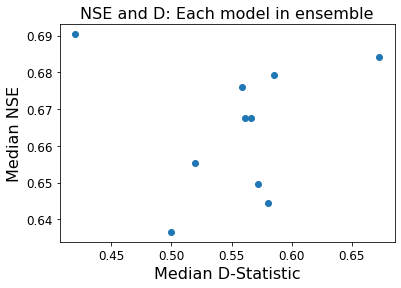

In [ ]:
#are NSE and D (K-S statistic) related?

x = np.median(ks_fine, axis = 1)
y = np.median(NSE_fine_runs, axis = 1)

fs = 16

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel('Median D-Statistic', fontsize = fs)
ax.set_ylabel('Median NSE', fontsize = fs)
ax.set_title('NSE and D: Each model in ensemble', fontsize = fs)
ax.tick_params(labelsize = fs - 4)

plt.show()

In [ ]:
r,p = pearsonr(x,y)
rangeD = np.max(x) - np.min(x)
rangeNSE = np.max(y) - np.min(y)

print('NSE and D for each model run have correlation coefficient: ' + str(np.round(r, decimals = 2)))
print('with p-value: ' + str(np.round(p, decimals = 2)))
print('')
print('Range of D: ' + str(np.round(rangeD, decimals = 2)))
print('Range of NSE: '  + str(np.round(rangeNSE, decimals = 2)))


NSE and D for each model run have correlation coefficient: 0.05
with p-value: 0.9

Range of D: 0.25
Range of NSE: 0.05
